## Netflix Movies and TV Shows

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pickle

import warnings
warnings.filterwarnings("ignore")

## Carga do Dataset

O dataset contém informações sobre filmes e séries disponíveis na Netflix, incluindo título, gênero, país, data de adição, classificação etária, duração, tipo (filme ou série) e descrição.

Descrição de cada coluna:
- show_id: Identificador único do show.
- type: Tipo do show (Filme ou Série).
- title: Título do show.
- director: Diretor do show.
- cast: Elenco do show.
- country: País de origem do show.
- date_added: Data em que o show foi adicionado à Netflix.
- release_year: Ano de lançamento do show.
- rating: Classificação etária do show.
- duration: Duração do show (em minutos para filmes, número de temporadas para séries).
- listed_in: Gêneros do show.

In [13]:
# Carrega o dataset
data = pd.read_csv('../data/netflix_titles.csv')

# Exibe informações básicas do dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [14]:
# Mostra as primeiras linhas do dataset
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## Limpeza e seleção de colunas úteis

In [15]:
selected_features = ['country', 'release_year', 'rating', 'duration', 'listed_in']
data = data[['type'] + selected_features].dropna()

# Converter a coluna "duration" para minutos (filmes) ou temporadas (séries)
data['duration_int'] = data['duration'].str.extract('(\d+)').astype(int)

data = data.drop(columns=['duration'])


## Transformador de Dados

In [16]:
X = data.drop(columns=['type'])
y = data['type']

numeric_features = ['release_year', 'duration_int']
categorical_features = ['country', 'rating', 'listed_in']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Separação em conjunto de treino e conjunto de teste com holdout

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

## Modelagem com pipelines e gridsearch

In [18]:
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC()
}

param_grid = {
    'Decision Tree': {'clf__max_depth': [3, 5, 10]},
    'KNN': {'clf__n_neighbors': [3, 5, 7]},
    'Naive Bayes': {'clf__var_smoothing': [1e-9, 1e-8, 1e-7]},
    'SVM': {'clf__C': [0.1, 1, 10]}
}

best_models = {}
cv_results = {}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nTreinando modelo: {name}")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', model)
    ])
    # O GridSearchCV, que por baixo dos panos usa cross_val_score internamente quando recebe o argumento cv=skf
    grid = GridSearchCV(pipeline, param_grid[name], cv=skf, scoring='accuracy', return_train_score=True)
    grid.fit(X_train, y_train)
    
    print("Melhores hiperparâmetros:", grid.best_params_)
    y_pred = grid.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    best_models[name] = grid.best_estimator_
    cv_results[name] = grid.cv_results_['mean_test_score']


Treinando modelo: Decision Tree
Melhores hiperparâmetros: {'clf__max_depth': 3}
Accuracy: 0.998745294855709
              precision    recall  f1-score   support

       Movie       1.00      1.00      1.00      1137
     TV Show       1.00      1.00      1.00       457

    accuracy                           1.00      1594
   macro avg       1.00      1.00      1.00      1594
weighted avg       1.00      1.00      1.00      1594


Treinando modelo: KNN
Melhores hiperparâmetros: {'clf__n_neighbors': 3}
Accuracy: 0.9981179422835633
              precision    recall  f1-score   support

       Movie       1.00      1.00      1.00      1137
     TV Show       1.00      1.00      1.00       457

    accuracy                           1.00      1594
   macro avg       1.00      1.00      1.00      1594
weighted avg       1.00      1.00      1.00      1594


Treinando modelo: Naive Bayes
Melhores hiperparâmetros: {'clf__var_smoothing': 1e-07}
Accuracy: 0.9974905897114178
              preci

## Comparar resultados

In [19]:
print("\n\n== Comparativo de Modelos ==")
accs = []
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accs.append(acc)
    print(f"{name}: {acc:.4f}")



== Comparativo de Modelos ==
Decision Tree: 0.9987
KNN: 0.9981
Naive Bayes: 0.9975
SVM: 0.9981


## Boxplot de comparação

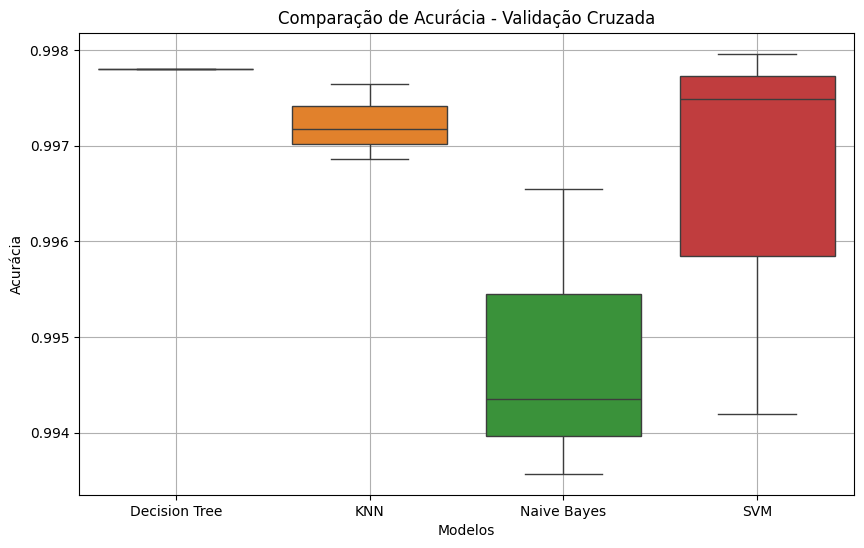

In [20]:
cv_scores_df = pd.DataFrame(dict([(k, v) for k, v in cv_results.items()]))
plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_scores_df)
plt.title('Comparação de Acurácia - Validação Cruzada')
plt.ylabel('Acurácia')
plt.xlabel('Modelos')
plt.grid(True)
plt.show()


## Exporta o melhor modelo

In [21]:
melhor_modelo = max(best_models.items(), key=lambda x: accuracy_score(y_test, x[1].predict(X_test)))
with open('../models/netflix_classification.pkl', 'wb') as f:
    pickle.dump(melhor_modelo[1], f)
print(f"\nModelo exportado: {melhor_modelo[0]}")


Modelo exportado: Decision Tree


## Simulação com dados não vistos

In [22]:
novo_dado = pd.DataFrame([{
    'country': 'United States',
    'release_year': 2023,
    'rating': 'TV-MA',
    'listed_in': 'Dramas, International TV Shows',
    'duration_int': 2
}])

predicao = melhor_modelo[1].predict(novo_dado)
print(f"\nPredição para novo dado: {predicao[0]}")


Predição para novo dado: TV Show
